In [1]:
# os.chdir("hmr4d/")
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch
from pytorch3d.transforms import matrix_to_axis_angle

from hmr4d.utils.preproc import Tracker, Extractor
from hmr4d.utils.geo.hmr_cam import get_bbx_xys_from_xyxy, estimate_K
from hmr4d.utils.geo.hmr_cam import compute_transl_full_cam
from hmr4d.utils.preproc.vitfeat_extractor import get_batch
from hmr4d.utils.body_model import BodyModelSMPLH
from hmr4d.utils.video_io_utils import get_writer
from hmr4d.utils.vis.cv2_utils import draw_bbx_xyxy_on_image_batch
from hmr4d.utils.vis.renderer import Renderer

/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### 1. parse_args_to_cfg

In [23]:
# demo.py -> L41~55
video_path = Path("samples/test_dataset/Dk1-58PJbMA=2.mp4")
output_root = Path("outputs/test_dataset-hmr")
output_root.mkdir(parents=True, exist_ok=True)
static_cam = False
use_dpvo = False
f_mm = None


# demo.py -> L60
# hmr4d.utils.video_io_utils.get_video_lwh
length, height, width, c = iio.improps(video_path, plugin="pyav").shape
if length == 0:
    video = cv2.VideoCapture(str(video_path))
    fps = video.get(cv2.CAP_PROP_FPS)
    length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))-1
print(f"{str(video_path)}: {width}x{height}x{length}")

samples/test_dataset/Dk1-58PJbMA=2.mp4: 1920x1080x120


### 2. Run Preprocess

In [11]:
tracker = Tracker()
extractor = Extractor()

In [24]:
track_history = tracker.track(video_path)
vid_length = len(track_history)
id_to_frame_ids, id_to_bbx_xyxys, id_sorted = tracker.sort_track_length(track_history, video_path)

for k in id_sorted:
    lst = id_to_frame_ids[k]
    ranges = np.split(lst, np.where(np.diff(lst)!=1)[0]+1)
    ranges = [(x[0], x[-1]) if len(x) > 1 else (x[0], x[0]) for x in ranges]
    print(f"track id {k}: {len(lst)} frames, ranges: {ranges}")

# bbx_xyxy = tracker.get_one_track(video_path, track_id=107).float()  # (L, 4)
# # bbx_xyxy = tracker.get_one_track(video_path, imgsize=960, track_id=1, print_res=True).float()
# bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

YoloV8 Tracking: 100%|██████████| 120/120 [00:03<00:00, 34.12it/s]

track id 1: 96 frames, ranges: [(0, 78), (80, 84), (87, 87), (108, 108), (110, 119)]
track id 3: 73 frames, ranges: [(0, 71), (73, 73)]
track id 2: 50 frames, ranges: [(0, 9), (11, 44), (46, 51)]
track id 5: 89 frames, ranges: [(0, 70), (72, 76), (82, 91), (109, 111)]
track id 6: 50 frames, ranges: [(0, 16), (18, 27), (36, 36), (38, 45), (47, 48), (52, 63)]
track id 7: 60 frames, ranges: [(0, 15), (17, 21), (31, 31), (33, 34), (36, 37), (39, 39), (42, 44), (49, 50), (64, 66), (68, 69), (72, 76), (81, 82), (84, 91), (109, 116)]
track id 8: 49 frames, ranges: [(0, 36), (38, 38), (40, 40), (42, 43), (46, 51), (54, 54), (65, 65)]
track id 9: 31 frames, ranges: [(0, 8), (16, 19), (21, 22), (24, 35), (37, 37), (56, 57), (63, 63)]
track id 4: 5 frames, ranges: [(0, 4)]
track id 12: 7 frames, ranges: [(55, 55), (57, 61), (63, 63)]
track id 11: 6 frames, ranges: [(5, 5), (7, 7), (9, 9), (12, 12), (14, 15)]
track id 10: 3 frames, ranges: [(3, 5)]


In [25]:
track_ids = [1]
frame_ids, bbx_xyxys = [], []
for track_id in track_ids:
    tmp_id = torch.tensor(id_to_frame_ids[track_id])  # (N,)
    frame_ids.append(tmp_id)
    tmp_xyxy = torch.tensor(id_to_bbx_xyxys[track_id])  # (N, 4)
    bbx_xyxys.append(tmp_xyxy)
frame_ids = torch.cat(frame_ids)
bbx_xyxys = torch.cat(bbx_xyxys)

bbx_xyxy = tracker.interpolate_smooth_bbx(frame_ids, bbx_xyxys, length=vid_length)
bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

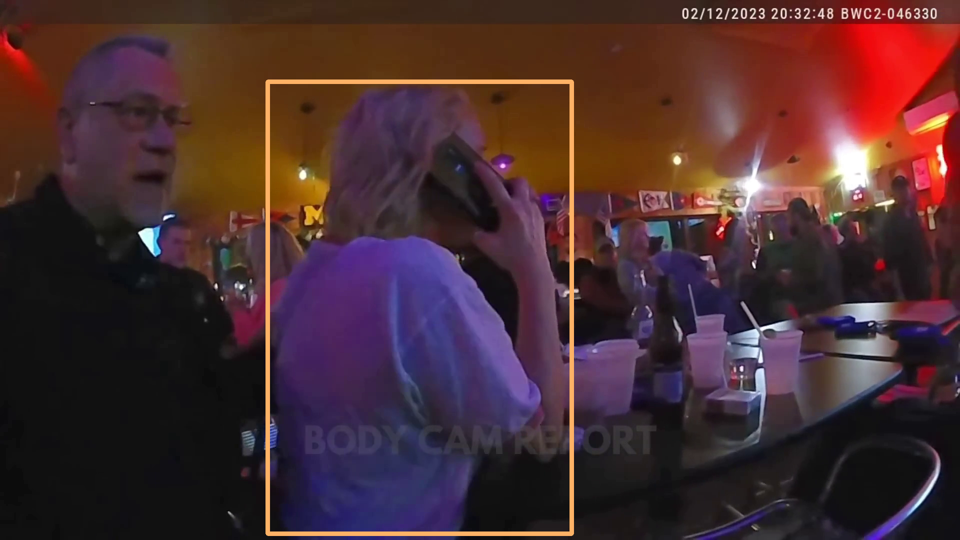

In [27]:
i = 50
img = iio.imread(video_path, index=i)  # (L, H, W, 3) RGB
video_overlay = draw_bbx_xyxy_on_image_batch(bbx_xyxy[i:i+1], [img], thickness=8)
Image.fromarray(video_overlay[0]).resize((width // 2, height // 2))

In [28]:
vit_imgs, _ = get_batch(video_path, bbx_xys, img_ds=0.5, rotate=0)
K_fullimg = estimate_K(width, height).repeat(len(vit_imgs), 1, 1)

with torch.no_grad():
    x = vit_imgs[:, :, :, 32:-32].to('cuda')
    vit_feats = extractor.extractor.backbone(x)

    pred_smpl_params, pred_cam, _, token_out = extractor.extractor.smpl_head(vit_feats, only_return_token_out=False)
    smpl_params = {
        "body_pose": matrix_to_axis_angle(pred_smpl_params["body_pose"]).flatten(-2),  # (B, 23, 3)
        "betas": pred_smpl_params["betas"],  # (B, 10)
        "global_orient": matrix_to_axis_angle(pred_smpl_params["global_orient"])[:, 0],  # (B, 3)
        "transl": compute_transl_full_cam(pred_cam, bbx_xys.to('cuda'), K_fullimg.to('cuda')),
        # "transl": pred_cam     
    }

In [29]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).cuda()
renderer_c = Renderer(width, height, device="cuda", faces=smpl.faces, K=estimate_K(width, height))

smpl_c = smpl(**smpl_params)
pred_c_verts = smpl_c.vertices

writer = get_writer(output_root / f'{video_path.stem}.mp4', fps=30, crf=23)
# writer = get_writer(f'tmp.mp4', fps=30, crf=23)
for i in tqdm(range(length), desc=f"Rendering Global"):
    img_raw = cv2.resize(iio.imread(video_path, index=i), (width, height))
    img_cam = renderer_c.render_mesh(pred_c_verts[i].cuda(), img_raw, colors=[0.8, 0.8, 0.8])
    writer.write_frame(img_cam)
writer.close()

Rendering Global: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]
